In [22]:
# command to set matplotlib images to be displayed in jupyter notebook itself
%matplotlib inline

import numpy as np
import cPickle
import os
import urllib2
import csv
import cv2

from matplotlib.pyplot import imshow
from PIL import Image
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras import optimizers

In [23]:
# dictionaries to fetch labels from their integer index
label_dict_type = {24: 'Synthetic', 3: 'Canvas',27:'Velvet',7: 'Fabric', 
              6: 'EVA',18: 'Rubber',12: 'Loafers',22: 'Sneakers',14: 'Napa', 
              9: 'Flats',1:  'Bellies',25: 'Synthetic Leather',16: 'PU', 
              17: 'PVC',19: 'Running',13: 'Mesh',21: 'Slippers',20: 'Sandals', 
              10: 'Formal',26: 'TPC',23: 'Suede',8: 'Faux Leather', 
              28: 'Wedges',15: 'Phylon', 4: 'Canvas Shoes',2: 'Boots',
              11: 'Heels',5: 'Casual'}

label_dict_color = {1: 'Beige', 2: 'Black', 3: 'Blue', 4: 'Brown', 5: 'Copper', 6: 'Cream', 7: 'Golden', 
                    8: 'Green', 9: 'Grey', 10: 'Maroon', 11: 'Multi', 12: 'Orange', 13: 'Peach', 14: 'Pink', 
                    15: 'Purple', 16: 'Red', 17: 'Silver', 18: 'Tan', 19: 'Violet', 20: 'White', 21: 'Yellow'}

In [25]:
# Building the structure of VGGNet(with 16 layers)
def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2), dim_ordering="th"))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2), dim_ordering="th"))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2), dim_ordering="th"))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2), dim_ordering="th"))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2), dim_ordering="th"))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(11, activation='softmax'))
    
    if weights_path:
        model.load_weights(weights_path, by_name=True)
        
    #Remove the last two layers to get the 4096D activations
    model.layers.pop()
    model.layers.pop()
    model.outputs = [model.layers[-1].output]
    model.layers[-1].outbound_nodes = []

    return model
    

In [26]:
# Loading the pretrained weights for VGGNet
model = VGG_16('vgg16_weights_tf_dim_ordering_tf_kernels.h5')

# Compiling the model with stochastic gradient descent optimizer
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
# 'sparse_categorical_crossentropy' loss can be used as alternative to one hot vectors if number of classes are large
model.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
# Fitting pca on type data
train_images_type = np.load('type_image_arr_4096.npy')
pca_type = PCA(n_components=1024, whiten=True).fit(train_images_type)

# Fitting pca on color data
train_images_color = np.load('color_image_arr_4096.npy')
pca_color = PCA(n_components=512, whiten=True).fit(train_images_color)

In [28]:
# load classifiers
with open('type_classifier_1024.pkl', 'rb') as fid:
    type_classifier = cPickle.load(fid)
    
with open('color_classifier_512.pkl', 'rb') as fid:
    color_classifier = cPickle.load(fid)

In [35]:
def make_prediction(im_url):
    """
    This function performs following actions:
    - Fetch the image from url
    - Convert image vector to dimensions suitable for VGGNet input
    - Obtain (,4096) dimension vector and apply pca to get arrays for type(1024 dimension) and color(512 dimension)
    - Predict [type] and [color] of the image using trained SVM_classifiers
    Input: (image_url)
    """
    # try fetching the image from url, print error message in case of exception
    try:
        img = Image.open(urllib2.urlopen(im_url))
        # Displaying image
        imshow(img)
        img = np.array(img)
    except Exception as e:
        print 'Error loading image from url'
    # read image as a vector and adjust its dimension according to the input dimensions of VGGNet
    img = cv2.resize(img, (224,224))
    img = img.transpose((2,0,1))
    img = np.expand_dims(img, axis=0)
    x_4096 = model.predict(img)
    # applying pca 4096=>1024
    x_type = pca_type.transform(x_4096)
    x_color = pca_color.transform(x_4096)
    pred_type = np.ndarray.tolist(type_classifier.predict(x_type))
    pred_color = np.ndarray.tolist(color_classifier.predict(x_color))
    print "Type :: %s" % label_dict_type[pred_type[0]]
    print "Color :: %s" % label_dict_color[pred_color[0]]

Type :: Boots
Color :: Black


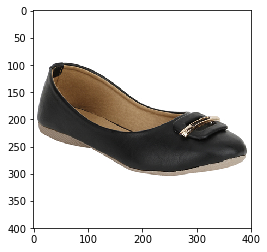

In [38]:
if __name__ == '__main__':
    make_prediction('https://assetscdn.paytm.com/images/catalog/product/F/FO/FOOHANNA-BLACK-NAMA1059605C94CD7F/2.jpg')